# Import Modules and Libraries

This code cell imports the necessary Python libraries for data manipulation, numerical operations, and plotting.

In [ ]:
!pip install session-info

In [ ]:
# 📦 Data Manipulation
import pandas as pd
import numpy as np
from itertools import product

# 📊 Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 🧮 Modeling & Evaluation
import lightgbm as lgb
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_pinball_loss

# 🔧 Utilities
from tqdm import tqdm
from scipy.interpolate import interp1d

In [ ]:
# Create the requirements.txt file
import session_info
session_info.show(write_req_file=True, req_file_name='requirements.txt')

/usr/local/lib/python3.11/dist-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


# Data Cleaning and Promo Effect Adjustment

## 🧹 Preprocessing & Cleaning Sales Time Series Data

This section loads and processes the merged sales data (`merged_data.csv`) to create a complete, clean, and model-ready time series for each unique **item-store combination**.

### 🔧 Key Steps

- **Load and format data**  
  Convert date strings to `datetime` format and create a composite key (`combo`) for easy tracking of `(item_id, store_id)` pairs.

- **Ensure complete daily time index**  
  For each item-store group, generate a full date range and merge it with existing data to fill in missing days.

- **Fill regular prices**  
  Forward-fill `regular_price` to handle missing values, assuming prices are stable or increase over time.

- **Identify and flag missing sales dates**  
  Mark dates with no recorded sales as missing (`missing_dates_flag`), to be handled later.

- **Temporary interpolation for stats**  
  Use linear interpolation on sales to estimate missing values for the purpose of **outlier detection only** (`sales_temp`).

- **Outlier detection (IQR method)**  
  - Apply IQR filtering only on **non-promo, non-missing** sales data.
  - Flag values beyond 1.5×IQR from Q1/Q3 as outliers (`outlier_flag`).

- **Detect abnormal zero-sales periods**  
  - Identify consecutive sequences of zero sales.
  - If the zero run exceeds a certain threshold (default: `3` days), flag it as a potential stockout or anomaly (`zero_sales_outlier`).

- **Final interpolation**  
  Mark outliers and missing values as NaN in `sales`, and then interpolate linearly to fill them.

- **Promo effect estimation**  
  - Compute average sales during **promo** and **non-promo** days using only clean (non-interpolated) data.
  - Estimate the relative sales uplift from promotions (`promo_lift`).

- **Create depromo-adjusted sales column**  
  Remove the average promo effect from promo-day sales to get `sales_depromo`, an estimate of sales as if no promotions occurred.

- **Aggregate all results**  
  Append processed groups back together into `filled_df`, clean up temp columns, and sort the final dataset.

### 📌 Notes

- `sales_temp` is never used in the final output—it’s only used to detect statistical outliers.
- We can adjust the zero-run threshold depending on the business domain or inventory behavior.
- This preprocessing pipeline improves the quality of training data by handling missing data, smoothing outliers, and neutralizing promo effects.




In [ ]:
# Load and prepare data
df = pd.read_csv("merged_data.csv")
df['daydt'] = pd.to_datetime(df['daydt'])
df['combo'] = df['item_id'] + ' / ' + df['store_id']

filled_df = pd.DataFrame()

# Iterate per item/store combo
for (item, store), group in df.groupby(['item_id', 'store_id']):
    # Create full date range for the group
    full_dates = pd.DataFrame({'daydt': pd.date_range(group['daydt'].min(), group['daydt'].max())})

    # Merge with existing data
    merged = full_dates.merge(group, on='daydt', how='left').reset_index(drop=True)

    # Fill in item/store info for missing rows
    merged['item_id'] = item
    merged['store_id'] = store
    merged['combo'] = f"{item} / {store}"

    # Sort before filling
    merged = merged.sort_values('daydt')

    # Forward fill regular_price (only forward)
    merged['regular_price'] = merged['regular_price'].ffill()

    # Flag missing sales dates
    merged['missing_dates_flag'] = merged['sales'].isna().astype(int)

    # Convert sales to float (important for interpolation)
    merged['sales'] = merged['sales'].astype(float)

    # Save original sales before interpolation
    merged['sales_original'] = merged['sales']

    # Temporary interpolation to fill missing for stats calculation
    merged['sales_temp'] = merged['sales'].interpolate(method='linear', limit_direction='both')

    # IQR calculation mask: exclude missing dates and promo days
    iqr_mask = (merged['missing_dates_flag'] == 0) & (merged['promo_flag'] == 0)

    q1 = merged.loc[iqr_mask, 'sales_temp'].quantile(0.25)
    q3 = merged.loc[iqr_mask, 'sales_temp'].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Flag outliers on non-promo days based on IQR bounds
    merged['outlier_flag'] = (
        (merged['promo_flag'] == 0) &
        ((merged['sales_temp'] < lower_bound) | (merged['sales_temp'] > upper_bound))
    ).astype(int)

    # Detect consecutive zero sales runs and flag long runs as outliers
    merged['zero_sales_flag'] = (merged['sales_temp'] == 0).astype(int)
    merged['zero_sales_group'] = (merged['zero_sales_flag'] != merged['zero_sales_flag'].shift(1)).cumsum()
    zero_runs = merged.groupby('zero_sales_group')['zero_sales_flag'].transform('sum')
    threshold = 3  # adjust as needed
    merged['zero_sales_outlier'] = ((merged['zero_sales_flag'] == 1) & (zero_runs >= threshold)).astype(int)

    # Combine missing dates and outliers into interpolated_flag
    merged['interpolated_flag'] = (
        (merged['missing_dates_flag'] == 1) |
        (merged['outlier_flag'] == 1) |
        (merged['zero_sales_outlier'] == 1)
    ).astype(int)


    # Set sales to NaN for missing + outliers for final interpolation
    merged.loc[merged['interpolated_flag'] == 1, 'sales'] = pd.NA

    # Final interpolation after marking outliers as NaN
    merged['sales'] = merged['sales'].interpolate(method='linear', limit_direction='both')

    # Estimate promo effect (only use clean data without interpolations)
    promo_mask = (merged['promo_flag'] == 1) & (merged['interpolated_flag'] == 0)
    nonpromo_mask = (merged['promo_flag'] == 0) & (merged['interpolated_flag'] == 0)

    avg_promo = merged.loc[promo_mask, 'sales'].mean()
    avg_nonpromo = merged.loc[nonpromo_mask, 'sales'].mean()

    promo_lift = (avg_promo - avg_nonpromo) / avg_nonpromo if avg_nonpromo and not pd.isna(avg_nonpromo) else 0

    # Create sales column with promo effect removed
    merged['sales_depromo'] = merged['sales']
    merged.loc[merged['promo_flag'] == 1, 'sales_depromo'] = merged.loc[merged['promo_flag'] == 1, 'sales'] / (1 + promo_lift)

    # Append processed group to final dataframe
    filled_df = pd.concat([filled_df, merged], ignore_index=True)

# Sort final dataframe
filled_df = filled_df.sort_values(by=['store_id', 'item_id', 'daydt']).drop(columns=['sales_value', 'sales_temp', 'zero_sales_group', 'zero_sales_flag']).reset_index(drop=True)

## 📊 Interactive Visualization of Sales & Price Time Series

This section creates an interactive Plotly figure to inspect the sales and pricing data for each **item-store combo** after preprocessing.

The visualization is designed to help evaluate:
- The quality of interpolation
- The effect of promotions
- The accuracy of outlier detection
- How price changes relate to sales patterns

---

### 🧱 Plot Structure

The figure contains **two rows** of subplots:
1. **Sales Time Series**
2. **Price Comparison**

Each combo can be selected interactively using a **dropdown menu** that updates the traces shown.

---

### 📈 Row 1: Sales Traces
Each time series is visualized with multiple trace types:

- **Original Sales** (gray dotted line)  
  Raw sales before any interpolation or cleaning.

- **Interpolated Sales** (blue line with markers)  
  Final sales values after handling missing data and outliers.

- **De-promo Sales** (green dotted line)  
  Sales with the estimated promo effect removed.

- **Promo Days** (orange diamonds)  
  Highlight when promotions were active.

- **Missing Dates** (red Xs)  
  Days where sales data was missing.

- **IQR Outliers** (red triangles)  
  Sales points flagged as statistical outliers based on the IQR rule.

- **Interpolated Points** (purple crosses)  
  Points that were interpolated due to missingness or outliers.

---

### 💰 Row 2: Price Comparison

- **Regular Price** (blue line)  
  Standard item price over time.

- **Promo Price** (orange dashed line)  
  Promotional price, if available.

---

### 🔄 Interactivity

- A **dropdown menu** allows the user to select and inspect a specific item-store combo.
- Only the relevant traces for the selected combo are displayed at once.
- The visibility is controlled using the `legendgroup` and a custom `steps` list for the `updatemenus`.

---

### 📝 Notes

- The variable `num_traces_per_combo` defines how many Plotly traces are created per combo. It must align with the number of unique traces per group (sales + price related).
- The initial state of the plot shows the **first combo** by default.
- This visualization helps in **debugging data cleaning steps** and validating **promo effect estimation** visually.


In [ ]:
num_traces_per_combo = 9

# Create subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("Sales with Promo, Missing, and Interpolated", "Price Comparison")
)

for combo in filled_df['combo'].unique():
    sub_df = filled_df[filled_df['combo'] == combo]

    # --- Row 1: Sales Time Series ---

    # sales_original
    fig.add_trace(go.Scatter(
        x=sub_df['daydt'], y=sub_df['sales_original'],
        mode='lines', name='Original Sales',
        line=dict(color='gray', dash='dot'),
        visible=False,
        legendgroup=combo,
        showlegend=True
    ), row=1, col=1)

    # final sales (after interpolation, before depromo)
    fig.add_trace(go.Scatter(
        x=sub_df['daydt'], y=sub_df['sales'],
        mode='lines+markers', name='Interpolated Sales',
        line=dict(color='blue'),
        visible=False,
        legendgroup=combo,
        showlegend=True
    ), row=1, col=1)

    # depromo sales
    fig.add_trace(go.Scatter(
        x=sub_df['daydt'], y=sub_df['sales_depromo'],
        mode='lines', name='De-promo Sales',
        line=dict(color='green', dash='dot'),
        visible=False,
        legendgroup=combo,
        showlegend=True
    ), row=1, col=1)

    # promo days
    promo_mask = (sub_df['promo_flag'] == 1) & (~sub_df['sales'].isna())
    fig.add_trace(go.Scatter(
        x=sub_df.loc[promo_mask, 'daydt'],
        y=sub_df.loc[promo_mask, 'sales'],
        mode='markers',
        name='Promo Day',
        marker=dict(color='orange', size=8, symbol='diamond'),
        visible=False,
        legendgroup=combo,
        showlegend=True
    ), row=1, col=1)

    # missing dates
    missing_mask = sub_df['missing_dates_flag'] == 1
    fig.add_trace(go.Scatter(
        x=sub_df.loc[missing_mask, 'daydt'],
        y=[0]*missing_mask.sum(),
        mode='markers',
        name='Missing Date',
        marker=dict(color='red', size=6, symbol='x'),
        visible=False,
        legendgroup=combo,
        showlegend=True
    ), row=1, col=1)

    # outliers
    outlier_mask = sub_df['outlier_flag'] == 1
    fig.add_trace(go.Scatter(
        x=sub_df.loc[outlier_mask, 'daydt'],
        y=[0]*outlier_mask.sum(),
        mode='markers',
        name='IQR Outlier',
        marker=dict(color='red', size=8, symbol='triangle-up'),
        visible=False,
        legendgroup=combo,
        showlegend=True
    ), row=1, col=1)

    # interpolated points
    interp_mask = sub_df['interpolated_flag'] == 1
    fig.add_trace(go.Scatter(
        x=sub_df.loc[interp_mask, 'daydt'],
        y=sub_df.loc[interp_mask, 'sales'],
        mode='markers',
        name='Interpolated Point',
        marker=dict(color='purple', size=10, symbol='cross'),
        visible=False,
        legendgroup=combo,
        showlegend=True
    ), row=1, col=1)

    # --- Row 2: Price Comparison ---

    fig.add_trace(go.Scatter(
        x=sub_df['daydt'], y=sub_df['regular_price'],
        mode='lines', name='Regular Price',
        line=dict(color='blue'),
        visible=False,
        legendgroup=combo,
        showlegend=True
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=sub_df['daydt'], y=sub_df['promo_price'],
        mode='lines', name='Promo Price',
        line=dict(color='orange', dash='dot'),
        visible=False,
        legendgroup=combo,
        showlegend=True
    ), row=2, col=1)

# --- Dropdown menu ---
steps = []
combo_list = filled_df['combo'].unique()
for i, combo in enumerate(combo_list):
    visibility = [False] * len(fig.data)
    base = i * num_traces_per_combo

    for j in range(num_traces_per_combo):
        visibility[base + j] = True

    # Price traces (last 2)
    visibility[base + 6] = True  # regular_price
    visibility[base + 7] = True  # promo_price

    steps.append(dict(
        method='update',
        args=[{'visible': visibility}],
        label=combo
    ))

# Layout
fig.update_layout(
    height=750,
    title="Sales and Prices with Promo, Missing, Outliers and Interpolated Points",
    updatemenus=[dict(
        active=0,
        buttons=steps,
        x=0,
        xanchor='left',
        y=1.1,
        yanchor='top'
    )],
    legend=dict(
        x=1,
        xanchor='right',
        y=1,
        yanchor='top'
    ),
    margin=dict(t=130)
)

# Show first combo
for i in range(num_traces_per_combo):
    fig.data[i].visible = True

# Axes
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=1)
fig.update_yaxes(title_text="Price", row=2, col=1)

fig.show()


In [ ]:
filled_df.head()

,daydt,item_id,store_id,sales,regular_price,promo_price,promo_flag,combo,missing_dates_flag,sales_original,outlier_flag,zero_sales_outlier,interpolated_flag,sales_depromo
0,2019-01-02,item1,store1,9.0,285.0,NaN,0.0,item1 / store1,0,9.0,0,0,0,9.0
1,2019-01-03,item1,store1,8.0,285.0,NaN,0.0,item1 / store1,0,8.0,0,0,0,8.0
2,2019-01-04,item1,store1,1.0,285.0,NaN,0.0,item1 / store1,0,1.0,0,0,0,1.0
3,2019-01-05,item1,store1,7.0,285.0,NaN,0.0,item1 / store1,0,7.0,0,0,0,7.0
4,2019-01-06,item1,store1,2.0,285.0,NaN,0.0,item1 / store1,0,2.0,0,0,0,2.0


# Data Checks

## 📊 Distribution Overview of Sales and Prices

This section generates a **4-panel summary plot** to visualize the distributions of sales (raw, cleaned, and de-promo adjusted) and prices.

The goal is to give a **global, aggregated view** of the data across all item-store combinations.

---

### 🔲 Subplot Layout (2×2 Grid)

1. **Top-Left: Original Sales Distribution**  
   Histogram showing raw sales values before any interpolation or outlier removal. Useful to observe the skewness, sparsity, or long tails in the original data.

2. **Top-Right: Cleaned Sales Distribution**  
   Histogram of `sales` after filling in missing values and removing anomalies. This reflects the data used for downstream modeling (excluding promo correction).

3. **Bottom-Left: De-Promo Sales Distribution**  
   Histogram of sales values after removing estimated promotional uplift. Helps in understanding baseline demand levels unaffected by marketing.

4. **Bottom-Right: Price Comparison (Box Plots)**  
   Box plots comparing `regular_price` and `promo_price` distributions:
   - Easy to see if promo prices are consistently lower.
   - Useful to detect outliers or data quality issues (e.g. missing promo prices).

---

### 📌 Notes

- **Histograms** use different `nbinsx` values to balance granularity and readability depending on distribution shape.
- **Box plots** omit raw data points (`boxpoints=False`) to keep the summary clean.
- These plots are valuable for **EDA (Exploratory Data Analysis)** and **validating preprocessing effects** at an aggregate level.


In [ ]:
# Distribution Visualizations
fig = make_subplots(rows=2, cols=2,
                   subplot_titles=('Original Sales Distribution',
                                  'Sales Distribution',
                                  'De Promo Sales Distribution',
                                  'Price Comparison'))

# Sales distribution
fig.add_trace(
    go.Histogram(x=filled_df['sales_original'], name='Original Sales', nbinsx=50),
    row=1, col=1
)

# Regular price distribution
fig.add_trace(
    go.Histogram(x=filled_df['sales'], name='Sales', nbinsx=30),
    row=1, col=2
)

# Promo price distribution
fig.add_trace(
    go.Histogram(x=filled_df['sales_depromo'], name='De-Promo Sales', nbinsx=30),
    row=2, col=1
)

# Price comparison box plot
fig.add_trace(
    go.Box(y=filled_df['regular_price'], name='Regular Price', boxpoints=False),
    row=2, col=2
)
fig.add_trace(
    go.Box(y=filled_df['promo_price'], name='Promo Price', boxpoints=False),
    row=2, col=2
)

fig.update_layout(height=900, width=1500, title_text="Distributions Overview")
fig.show()

## 📈 Monthly Sales Distribution Plotting Function

This section defines and uses a **flexible utility function** to plot total sales per month using different combinations of items and stores.

The function helps uncover **temporal sales patterns**, such as seasonality, trends, and sudden drops/spikes, across different hierarchical levels.

---

### 🧩 Function: `plot_monthly_sales_distribution`

#### 🔧 Parameters:
- `df`: The input DataFrame, must include at least: `'daydt'`, `'item_id'`, `'store_id'`, `'sales'`.
- `mode`: Controls what is plotted. Options:
  - `'all_stores_all_items'`: Show total sales across all items and stores.
  - `'all_stores_one_item'`: Filter to one item, show sales across all stores.
  - `'all_items_one_store'`: Filter to one store, show sales across all items.
  - `'all'`: Show all three plots.
- `item_id` *(optional)*: Required when `mode='all_stores_one_item'`.
- `store_id` *(optional)*: Required when `mode='all_items_one_store'`.

#### 🧠 Function Logic:
- Converts the `daydt` column to a `month` column (timestamped to the first day of each month).
- Groups data by month and aggregates total sales depending on the selected mode.
- Uses **Plotly Express** bar plots to create interactive visualizations.

---

### 📊 Example Calls & Output:

1. **All stores for one item**  
   ```python
   plot_monthly_sales_distribution(filled_df, mode='all_stores_one_item', item_id='item1')
    ```
  Shows monthly sales trend for a single item across every store.

2. **All items for one store**  
   ```python
   plot_monthly_sales_distribution(filled_df, mode='all_items_one_store', store_id='store1')
    ```
  Useful to inspect seasonal or operational patterns in a specific store.

3. **All stores and all items (total market view)**  
   ```python
   plot_monthly_sales_distribution(filled_df, mode='all_stores_all_items')
    ```
  Reveals overall sales trend — helpful for checking global seasonality or anomalies.

---

### 📌 Notes

- This function enables dynamic exploratory analysis at different levels without repeating code.
- It’s a great tool for validating:
  - Promotional campaign effects.
  - Inventory or supply chain issues.
  - Seasonality before forecasting.

In [ ]:
def plot_monthly_sales_distribution(
    df,
    mode='all',  # Options: 'all', 'all_items_one_store', 'all_stores_one_item', 'all_stores_all_items'
    item_id=None,
    store_id=None):
    """
    Generates a bar plot showing total monthly sales based on the selected mode and optional filters.

    This function takes a sales DataFrame and produces visualizations of monthly aggregated sales,
    optionally filtered by item and/or store. The type of plot generated depends on the selected mode.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing daily sales records. Must include the following columns:
        - 'daydt': date of the sale (datetime format)
        - 'item_id': identifier for the item
        - 'store_id': identifier for the store
        - 'sales': number of units sold

    mode : str, optional
        Determines how the data is grouped and plotted. Available modes typically include:
        - 'all': total sales across all items and stores
        - 'item': sales filtered by a specific item
        - 'store': sales filtered by a specific store
        - 'item-store': sales for a specific item in a specific store

    item_id : int or str, optional
        If provided, filters the data to include only the specified item.

    store_id : int or str, optional
        If provided, filters the data to include only the specified store.

    Returns:
    --------
    None
        Displays the bar plot directly using matplotlib or seaborn.
    """

    # Ensure datetime and month column
    df = df.copy()
    df['daydt'] = pd.to_datetime(df['daydt'])
    df['month'] = df['daydt'].dt.to_period('M').dt.to_timestamp()

    figs = []

    if mode in ['all', 'all_stores_all_items']:
        monthly_total_all = df.groupby('month')['sales'].sum().reset_index()
        fig = px.bar(monthly_total_all, x='month', y='sales',
                     title='Total Sales per Month (All Stores & Items)')
        figs.append(fig)

    if mode in ['all', 'all_stores_one_item']:
        if item_id is None:
            raise ValueError("Please specify `item_id` for mode='all_stores_one_item'")
        monthly_total_item = df[df['item_id'] == item_id].groupby('month')['sales'].sum().reset_index()
        fig = px.bar(monthly_total_item, x='month', y='sales',
                     title=f'Total Sales per Month (All Stores / Item: {item_id})')
        figs.append(fig)

    if mode in ['all', 'all_items_one_store']:
        if store_id is None:
            raise ValueError("Please specify `store_id` for mode='all_items_one_store'")
        monthly_total_store = df[df['store_id'] == store_id].groupby('month')['sales'].sum().reset_index()
        fig = px.bar(monthly_total_store, x='month', y='sales',
                     title=f'Total Sales per Month (All Items / Store: {store_id})')
        figs.append(fig)

    for fig in figs:
        fig.show()


In [ ]:
filled_df['combo'].unique()

array(['item1 / store1', 'item1 / store2', 'item2 / store2',
       'item4 / store2', 'item7 / store2', 'item5 / store3',
       'item6 / store3', 'item1 / store4', 'item6 / store4',
       'item7 / store4'], dtype=object)

In [ ]:
# Show only: all stores for one item
plot_monthly_sales_distribution(filled_df, mode='all_stores_one_item', item_id='item1')

# Show only: all items for one store
plot_monthly_sales_distribution(filled_df, mode='all_items_one_store', store_id='store1')

# Show only: all stores and all items (overall trend)
plot_monthly_sales_distribution(filled_df, mode='all_stores_all_items')

## 📅 Time Component Sales Distribution

This section introduces a powerful function that decomposes sales data along **calendar time components** to uncover hidden seasonality and behavioral trends across various levels of aggregation.

---

### 🧩 Function: `plot_time_component_sales_distribution`

#### 🔧 Parameters:
- `df`: Input DataFrame with at least the following columns:
  - `'daydt'`: Date column.
  - `'item_id'`, `'store_id'`, `'sales'`: For filtering and aggregation.
- `mode`: Determines which subset of the data is visualized. Options:
  - `'all_stores_all_items'`: Global sales behavior.
  - `'all_stores_one_item'`: Sales patterns for a single item across all stores.
  - `'all_items_one_store'`: Sales patterns for a single store.
  - `'one_item_one_store'`: Narrowest view — one item in one store.
  - `'all'`: Produces all of the above views in one go.
- `item_id`, `store_id`: Used to filter data when required by the selected mode.

---

### ⏳ What It Does:

The function analyzes **three time components**:
- **Month of Year**: Reveals annual seasonality patterns.
- **Week of Year**: Captures mid-level periodicity (e.g., summer spikes, holidays).
- **Day of Week**: Detects weekday/weekend shopping behaviors.

All plots are interactive bar charts, generated using **Plotly Express**.

---

### 🛠️ How It Works:

1. Converts the `'daydt'` column to datetime.
2. Extracts:
   - `month` and `month_name` (for ordered display).
   - `weekofyear` using ISO calendar.
   - `dayofweek` as categorical with weekday order preserved.
3. Aggregates total sales by each time component.
4. Generates **bar plots** for each time component across the selected data subset.

---

### 📊 Example Usage:

1. **Full Breakdown (All Modes + One Item/Store)**  
   ```python
   plot_time_component_sales_distribution(filled_df, mode='all', item_id='item1', store_id='store1')
   ```
   Displays all time-based breakdowns for:
   - All data
   - One item
   - One store
   - One item in one store

2. **Focused View – One Item, One Store**  
   ```python
   plot_time_component_sales_distribution(filled_df, mode='one_item_one_store', item_id='item1', store_id='store1')
   ```
   Useful for hyperlocal analysis (e.g., store-level forecasting).

---

### 📌 Why Use This?

These views help you:

- Spot weekly seasonality and promotion timing effects.
- Identify monthly and holiday trends.
- Understand if certain items spike on weekends or drop midweek.
- Aid in designing calendar-based features for time-series models.

In [ ]:
def plot_time_component_sales_distribution(
    df,
    mode='all',  # Options: 'all', 'all_stores_all_items', 'all_stores_one_item', 'all_items_one_store', 'one_item_one_store'
    item_id=None,
    store_id=None):
    """
    Generates bar plots of total sales aggregated by time components such as month, week of year, and day of week.

    This function visualizes sales patterns over different temporal groupings. It allows for optional filtering
    by item and/or store, and the behavior is controlled by the selected mode.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing daily sales data. Required columns include:
        - 'daydt': date of the sale (datetime format)
        - 'item_id': identifier for the item
        - 'store_id': identifier for the store
        - 'sales': number of units sold

    mode : str, optional
        Specifies the subset of data to visualize. Supported modes typically include:
        - 'all': sales across all items and stores
        - 'item': sales for a specific item
        - 'store': sales for a specific store
        - 'item-store': sales for a specific item in a specific store

    item_id : int or str, optional
        If provided, filters the data to include only sales of the specified item.

    store_id : int or str, optional
        If provided, filters the data to include only sales from the specified store.

    Returns:
    --------
    None
        Displays one or more bar plots showing the distribution of sales across time components.
    """

    df = df.copy()
    df['daydt'] = pd.to_datetime(df['daydt'])

    # Extract time components
    df['month_name'] = df['daydt'].dt.month_name()
    df['month'] = df['daydt'].dt.month
    df['weekofyear'] = df['daydt'].dt.isocalendar().week
    df['dayofweek'] = df['daydt'].dt.day_name()

    figs = []

    def make_bar_plot(grouped, x_col, title_suffix):
        return px.bar(grouped, x=x_col, y='sales', title=f'Total Sales by {x_col} ({title_suffix})')

    def process_subset(subset_df, title_suffix):
        # Month of Year
        monthly = subset_df.groupby(['month', 'month_name'])['sales'].sum().reset_index()
        monthly = monthly.sort_values('month')
        figs.append(make_bar_plot(monthly, 'month_name', f'Month of Year – {title_suffix}'))

        # Week of Year
        weekly = subset_df.groupby('weekofyear')['sales'].sum().reset_index()
        figs.append(make_bar_plot(weekly, 'weekofyear', f'Week of Year – {title_suffix}'))

        # Day of Week
        dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dow = subset_df.groupby('dayofweek')['sales'].sum().reset_index()
        dow['dayofweek'] = pd.Categorical(dow['dayofweek'], categories=dow_order, ordered=True)
        dow = dow.sort_values('dayofweek')
        figs.append(make_bar_plot(dow, 'dayofweek', f'Day of Week – {title_suffix}'))

    # 1. All stores & all items
    if mode in ['all', 'all_stores_all_items']:
        process_subset(df, "All Stores & Items")

    # 2. All stores / one item
    if mode in ['all', 'all_stores_one_item']:
        if item_id is None:
            raise ValueError("Please specify `item_id` for mode='all_stores_one_item'")
        df_item = df[df['item_id'] == item_id]
        process_subset(df_item, f"All Stores / Item: {item_id}")

    # 3. All items / one store
    if mode in ['all', 'all_items_one_store']:
        if store_id is None:
            raise ValueError("Please specify `store_id` for mode='all_items_one_store'")
        df_store = df[df['store_id'] == store_id]
        process_subset(df_store, f"All Items / Store: {store_id}")

    # 4. One item / one store
    if mode in ['all', 'one_item_one_store']:
        if item_id is None or store_id is None:
            raise ValueError("Please specify both `item_id` and `store_id` for mode='one_item_one_store'")
        df_combo = df[(df['item_id'] == item_id) & (df['store_id'] == store_id)]
        process_subset(df_combo, f"Item: {item_id} / Store: {store_id}")

    # Show all plots
    for fig in figs:
        fig.show()


In [ ]:
# View everything including lowest level
plot_time_component_sales_distribution(filled_df, mode='all', item_id='item1', store_id='store1')

# Only one item / one store
plot_time_component_sales_distribution(filled_df, mode='one_item_one_store', item_id='item1', store_id='store1')


# Feature Engineering

## 📅 Time-Based Sales Feature Engineering

This section implements time-aggregated and normalized features derived from sales data for each `(store_id, item_id)` pair. These features are useful for modeling **seasonality**, **weekly patterns**, and **temporal dynamics** in forecasting models.

### ✨ Motivation
In retail demand forecasting, aggregating sales over calendar dimensions (like month, week, and day of week) helps expose repetitive patterns and seasonality. We also compute lagged values and rolling averages to capture temporal dependencies, which are crucial for statistical or ML-based time series models.

---

### 📌 Functions Overview

1. **`get_all_store_item_time_distributions_df(df)`**
   - Aggregates sales for each store-item pair across:
     - **Months**
     - **ISO Weeks**
     - **Days of the Week**
   - Returns three DataFrames, each summarizing total sales by time component.

2. **`add_time_component_sales_features(df)`**
   - Enhances the original DataFrame by **joining total monthly/weekly/dow sales** back to each row using temporal keys (month, week number, weekday).
   - These raw aggregates are **not normalized** (i.e., they depend on how many days contribute to that period).

3. **`add_time_component_sales_features_normalized(df)`**
   - Computes **average sales per period** by normalizing total sales over the number of contributing days:
     - e.g., `monthly_avg_sales = monthly_total_sales / #days in month for this store-item`
   - Adds additional columns like `month_days`, `week_days`, `dow_days` to provide context for normalization.

4. **`add_time_component_sales_features_with_lags(df)`**
   - Extends the normalized features by introducing:
     - **Lagged averages** (`_lag1`) for months and weeks
     - **Rolling averages** (`_roll3`) over the last 3 periods
     - **3-day rolling averages** for day-of-week sales
   - Helps models capture temporal trends, moving averages, and recency effects.
   - Example features:
     - `monthly_avg_sales_lag1`: Average sales in the **previous month**
     - `weekly_avg_sales_roll3`: Mean of average sales over the **last 3 ISO weeks**

---

### 💡 Design Notes

- `.copy()` is used to prevent side-effects when modifying the DataFrame.
- `pd.to_datetime()` ensures robust handling of time-based operations.
- GroupBy logic ensures statistics are computed **per store-item**, making the features tailored to individual demand patterns.
- Sorting before computing lags/rolls ensures that rolling windows and shifts are aligned correctly with time.
- Day-of-week features are sorted manually (`Monday` → `Sunday`) to preserve human-readable order.
- For day-of-week, **lag is skipped** since days of the week are not inherently sequential (e.g., Monday doesn’t follow Sunday in a time-series sense).

---

### ✅ Usage Example

```python
# Apply feature engineering pipeline
filled_df_with_lags = add_time_component_sales_features_with_lags(filled_df)
```

This will return the input DataFrame with dozens of new features capturing both static patterns and temporal trends across time granularities.

In [ ]:
def get_all_store_item_time_distributions_df(df):
    """
    Computes aggregated sales distributions over month, ISO week, and day of week
    for each (store_id, item_id) combination.

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns ['store_id', 'item_id', 'sales', 'daydt'].

    Returns:
        tuple: A tuple containing three DataFrames:
            - monthly_df: Monthly total sales per store-item.
            - weekly_df: Weekly total sales per store-item.
            - dow_df: Day-of-week total sales per store-item.
    """
    df = df.copy()
    df['daydt'] = pd.to_datetime(df['daydt'])
    df['month_name'] = df['daydt'].dt.month_name()
    df['month'] = df['daydt'].dt.month
    df['weekofyear'] = df['daydt'].dt.isocalendar().week
    df['dayofweek'] = df['daydt'].dt.day_name()

    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    monthly_rows = []
    weekly_rows = []
    dow_rows = []

    for (store_id, item_id), group in df.groupby(['store_id', 'item_id']):
        # Monthly
        monthly = group.groupby(['month', 'month_name'])['sales'].sum().reset_index()
        monthly['store_id'] = store_id
        monthly['item_id'] = item_id
        monthly_rows.append(monthly)

        # Weekly
        weekly = group.groupby('weekofyear')['sales'].sum().reset_index()
        weekly['store_id'] = store_id
        weekly['item_id'] = item_id
        weekly_rows.append(weekly)

        # Day of Week
        dow = group.groupby('dayofweek')['sales'].sum().reset_index()
        dow['store_id'] = store_id
        dow['item_id'] = item_id
        dow['dayofweek'] = pd.Categorical(dow['dayofweek'], categories=dow_order, ordered=True)
        dow = dow.sort_values('dayofweek')
        dow_rows.append(dow)

    # Concatenate
    monthly_df = pd.concat(monthly_rows, ignore_index=True)
    weekly_df = pd.concat(weekly_rows, ignore_index=True)
    dow_df = pd.concat(dow_rows, ignore_index=True)

    return monthly_df, weekly_df, dow_df


def add_time_component_sales_features(df):
    """
    Adds aggregated sales features (monthly, weekly, and day of week total sales)
    to each record based on its timestamp.

    Parameters:
        df (pd.DataFrame): Input DataFrame with at least 'store_id', 'item_id', 'sales', and 'daydt' columns.

    Returns:
        pd.DataFrame: DataFrame with added columns:
            - 'monthly_total_sales'
            - 'weekly_total_sales'
            - 'dow_total_sales'
    """
    df = df.copy()
    df['daydt'] = pd.to_datetime(df['daydt'])
    df['month_name'] = df['daydt'].dt.month_name()
    df['month'] = df['daydt'].dt.month
    df['weekofyear'] = df['daydt'].dt.isocalendar().week
    df['dayofweek'] = df['daydt'].dt.day_name()

    # Compute aggregated stats
    monthly_df, weekly_df, dow_df = get_all_store_item_time_distributions_df(df)

    # Rename sales columns for clarity
    monthly_df = monthly_df.rename(columns={'sales': 'monthly_total_sales'})
    weekly_df = weekly_df.rename(columns={'sales': 'weekly_total_sales'})
    dow_df = dow_df.rename(columns={'sales': 'dow_total_sales'})

    # Merge back
    df = df.merge(monthly_df, on=['store_id', 'item_id', 'month', 'month_name'], how='left')
    df = df.merge(weekly_df, on=['store_id', 'item_id', 'weekofyear'], how='left')
    df = df.merge(dow_df, on=['store_id', 'item_id', 'dayofweek'], how='left')

    return df

def add_time_component_sales_features_normalized(df):
    """
    Adds normalized average sales features per month, week, and day of week to the DataFrame.
    These features are calculated by dividing total sales by the number of days in each period.

    Parameters:
        df (pd.DataFrame): Input DataFrame with at least 'store_id', 'item_id', 'sales', and 'daydt' columns.

    Returns:
        pd.DataFrame: DataFrame with added columns:
            - 'monthly_avg_sales', 'monthly_total_sales', 'month_days'
            - 'weekly_avg_sales', 'weekly_total_sales', 'week_days'
            - 'dow_avg_sales', 'dow_total_sales', 'dow_days'
    """
    df = df.copy()
    df['daydt'] = pd.to_datetime(df['daydt'])
    df['month_name'] = df['daydt'].dt.month_name()
    df['month'] = df['daydt'].dt.month
    df['weekofyear'] = df['daydt'].dt.isocalendar().week
    df['dayofweek'] = df['daydt'].dt.day_name()

    # Compute raw aggregated stats
    monthly_df, weekly_df, dow_df = get_all_store_item_time_distributions_df(df)

    # Compute counts (denominators)
    monthly_count = df.groupby(['store_id', 'item_id', 'month', 'month_name']).size().reset_index(name='month_days')
    weekly_count = df.groupby(['store_id', 'item_id', 'weekofyear']).size().reset_index(name='week_days')
    dow_count = df.groupby(['store_id', 'item_id', 'dayofweek']).size().reset_index(name='dow_days')

    # Merge counts into aggregates
    monthly_df = monthly_df.merge(monthly_count, on=['store_id', 'item_id', 'month', 'month_name'], how='left')
    weekly_df = weekly_df.merge(weekly_count, on=['store_id', 'item_id', 'weekofyear'], how='left')
    dow_df = dow_df.merge(dow_count, on=['store_id', 'item_id', 'dayofweek'], how='left')

    # Calculate normalized sales
    monthly_df['monthly_avg_sales'] = monthly_df['sales'] / monthly_df['month_days']
    weekly_df['weekly_avg_sales'] = weekly_df['sales'] / weekly_df['week_days']
    dow_df['dow_avg_sales'] = dow_df['sales'] / dow_df['dow_days']

    # Rename total sales cols for clarity
    monthly_df = monthly_df.rename(columns={'sales': 'monthly_total_sales'})
    weekly_df = weekly_df.rename(columns={'sales': 'weekly_total_sales'})
    dow_df = dow_df.rename(columns={'sales': 'dow_total_sales'})

    # Merge all into original dataframe
    df = df.merge(monthly_df, on=['store_id', 'item_id', 'month', 'month_name'], how='left')
    df = df.merge(weekly_df, on=['store_id', 'item_id', 'weekofyear'], how='left')
    df = df.merge(dow_df, on=['store_id', 'item_id', 'dayofweek'], how='left')

    return df

def add_time_component_sales_features_with_lags(df):
    """
    Adds time-based aggregated sales features and temporal dynamics like lags and rolling averages.

    Features added include:
        - Monthly average sales, its lag, and 3-period rolling average
        - Weekly average sales, its lag, and 3-period rolling average
        - Day-of-week average sales and its 3-day rolling average

    Parameters:
        df (pd.DataFrame): Input DataFrame with at least 'store_id', 'item_id', 'sales', and 'daydt' columns.

    Returns:
        pd.DataFrame: Enhanced DataFrame with added features including:
            - 'monthly_avg_sales', 'monthly_avg_sales_lag1', 'monthly_avg_sales_roll3'
            - 'weekly_avg_sales', 'weekly_avg_sales_lag1', 'weekly_avg_sales_roll3'
            - 'dow_avg_sales', 'dow_avg_sales_roll3'
            - Corresponding total sales and day counts per period
    """
    df = df.copy()
    df['daydt'] = pd.to_datetime(df['daydt'])
    df['month'] = df['daydt'].dt.month
    df['month_name'] = df['daydt'].dt.month_name()
    df['weekofyear'] = df['daydt'].dt.isocalendar().week
    df['dayofweek'] = df['daydt'].dt.day_name()

    # Base stats
    monthly_df, weekly_df, dow_df = get_all_store_item_time_distributions_df(df)

    # Count how many days contributed to each period
    monthly_counts = df.groupby(['store_id', 'item_id', 'month'])['daydt'].count().reset_index(name='month_days')
    weekly_counts = df.groupby(['store_id', 'item_id', 'weekofyear'])['daydt'].count().reset_index(name='week_days')
    dow_counts = df.groupby(['store_id', 'item_id', 'dayofweek'])['daydt'].count().reset_index(name='dow_days')

    # Merge counts
    monthly_df = monthly_df.merge(monthly_counts, on=['store_id', 'item_id', 'month'], how='left')
    weekly_df = weekly_df.merge(weekly_counts, on=['store_id', 'item_id', 'weekofyear'], how='left')
    dow_df = dow_df.merge(dow_counts, on=['store_id', 'item_id', 'dayofweek'], how='left')

    # Compute normalized avg sales
    monthly_df['monthly_avg_sales'] = monthly_df['sales'] / monthly_df['month_days']
    weekly_df['weekly_avg_sales'] = weekly_df['sales'] / weekly_df['week_days']
    dow_df['dow_avg_sales'] = dow_df['sales'] / dow_df['dow_days']

    # Sort for lag/rolling
    monthly_df = monthly_df.sort_values(['store_id', 'item_id', 'month'])
    weekly_df = weekly_df.sort_values(['store_id', 'item_id', 'weekofyear'])

    # Add lag and rolling means
    weekly_df['weekly_avg_sales_lag1'] = weekly_df.groupby(['store_id', 'item_id'])['weekly_avg_sales'].shift(1)
    weekly_df['weekly_avg_sales_roll3'] = (weekly_df.groupby(['store_id', 'item_id'])['weekly_avg_sales'].transform(lambda x: x.rolling(3, min_periods=1).mean()))

    monthly_df['monthly_avg_sales_lag1'] = monthly_df.groupby(['store_id', 'item_id'])['monthly_avg_sales'].shift(1)
    monthly_df['monthly_avg_sales_roll3'] = (monthly_df.groupby(['store_id', 'item_id'])['monthly_avg_sales'].transform(lambda x: x.rolling(3, min_periods=1).mean()))

    # Skip lag for DOW (not time-sequential) but still use rolling if needed
    dow_df['dow_avg_sales_roll3'] = dow_df.groupby(['store_id', 'item_id'])['dow_avg_sales'].transform(lambda x: x.rolling(3, min_periods=1).mean())

    # Rename raw totals for clarity
    monthly_df = monthly_df.rename(columns={'sales': 'monthly_total_sales'})
    weekly_df = weekly_df.rename(columns={'sales': 'weekly_total_sales'})
    dow_df = dow_df.rename(columns={'sales': 'dow_total_sales'})

    # Merge all into original
    df = df.merge(monthly_df, on=['store_id', 'item_id', 'month'], how='left')
    df = df.merge(weekly_df, on=['store_id', 'item_id', 'weekofyear'], how='left')
    df = df.merge(dow_df, on=['store_id', 'item_id', 'dayofweek'], how='left')

    return df

filled_df_with_lags = add_time_component_sales_features_with_lags(filled_df)

In [ ]:
# Add features to your original dataset
filled_df_with_time_features = add_time_component_sales_features(filled_df)
filled_df_with_normalized_features = add_time_component_sales_features_normalized(filled_df_with_time_features)
df = add_time_component_sales_features_with_lags(filled_df_with_normalized_features)


## 📅 **Date-Related Features**

| Column       | Description                                      | Why It's Useful                                                        |
| ------------ | ------------------------------------------------ | ---------------------------------------------------------------------- |
| `daydt`      | Timestamp of the observation (daily granularity) | The primary time axis — key for time-series alignment                  |
| `month_name` | Name of the month                                | Captures seasonality (e.g., holiday months, summer/winter behavior)    |
| `month`      | Numeric month (1-12)                             | Model-friendly version of `month_name`                                 |
| `weekofyear` | ISO week of the year                             | Captures intra-month and year-based patterns (e.g., spikes in week 52) |
| `dayofweek`  | Day name (e.g., Monday)                          | Helps model weekly cycles or dips (e.g., low Sunday sales)             |

---

## 🛒 **Core Identifiers + Sales Values**

| Column           | Description                                  | Why It's Useful                                 |
| ---------------- | -------------------------------------------- | ----------------------------------------------- |
| `item_id`        | Product ID                                   | Core forecasting unit (per item)                |
| `store_id`       | Store ID                                     | Allows multi-location modeling                  |
| `combo`          | `item_id / store_id` string (redundant here) | Used in grouping, not needed for model directly |
| `sales`          | Final cleaned and filled sales value         | Target variable (your prediction goal)          |
| `sales_original` | Original sales value (before interpolation)  | Useful for validation / error detection         |
| `sales_depromo`  | Sales value excluding promo influence        | Can help isolate organic demand                 |

---

## 📉 **Price + Promo Features**

| Column          | Description                       | Why It's Useful                                   |
| --------------- | --------------------------------- | ------------------------------------------------- |
| `regular_price` | Regular item price                | Models price elasticity or cost-based demand drop |
| `promo_price`   | Discounted price (if any)         | Models promotional price effect                   |
| `promo_flag`    | Boolean (1/0): Was item on promo? | Helps detect demand lift due to promotion         |

---

## 🧹 **Data Quality / Preprocessing Flags**

| Column               | Description                                     | Why It's Useful                                              |
| -------------------- | ----------------------------------------------- | ------------------------------------------------------------ |
| `missing_dates_flag` | Flag if the date was artificially inserted      | Helps identify synthetic values — can downweight in training |
| `interpolated_flag`  | Flag if the sales were interpolated (filled in) | Helps identify imputed data — useful for robustness          |
| `outlier_flag`       | Flag for detected extreme sales values          | May want to downweight/remove during model training          |
| `zero_sales_outlier` | Specific outlier detection for zero sales       | Often useful in demand models with stockouts or data issues  |

---

## 📊 **Monthly Aggregated Sales Features**

| Column                    | Description                                                      | Why It's Useful                                               |
| ------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------- |
| `monthly_total_sales_x/y` | Total sales per item/store in that month (raw, maybe duplicated) | Captures scale of monthly demand — helps with trend detection |
| `month_days_x/y`          | Number of days in month with valid data                          | Needed for normalization                                      |
| `monthly_avg_sales_x/y`   | Daily avg sales in that month                                    | Captures monthly seasonality smoothed by day count            |
| `monthly_avg_sales_lag1`  | Avg daily sales in previous month                                | Captures trend from month-to-month (e.g., growth or decay)    |
| `monthly_avg_sales_roll3` | Rolling 3-month average daily sales                              | Smoothed trend — useful for long-term seasonality modeling    |

---

## 📈 **Weekly Aggregated Sales Features**

| Column                   | Description                          | Why It's Useful                             |
| ------------------------ | ------------------------------------ | ------------------------------------------- |
| `weekly_total_sales_x/y` | Total sales in that week             | Weekly seasonality scale                    |
| `week_days_x/y`          | Number of days in the week with data | Normalize uneven week data                  |
| `weekly_avg_sales_x/y`   | Avg daily sales for that week        | Captures short-term trend and volatility    |
| `weekly_avg_sales_lag1`  | Previous week’s avg daily sales      | Weekly trend shift (decline/surge)          |
| `weekly_avg_sales_roll3` | Rolling 3-week average daily sales   | Smoothed week-to-week trend (reduces noise) |

---

## 📆 **Day-of-Week Sales Features**

| Column                | Description                                                    | Why It's Useful                                         |
| --------------------- | -------------------------------------------------------------- | ------------------------------------------------------- |
| `dow_total_sales_x/y` | Total sales on that weekday (e.g., all Mondays)                | Captures weekly cyclicality                             |
| `dow_days_x/y`        | Number of occurrences of that day                              | Normalize by number of Mondays, etc.                    |
| `dow_avg_sales_x/y`   | Avg sales on that day-of-week                                  | Helps model patterns like "low Sunday" or "peak Friday" |
| `dow_avg_sales_roll3` | Rolling 3-week average for each weekday (e.g., last 3 Mondays) | Smooths fluctuations, great for weekday-level modeling  |

---

## 🧠 **Why These Are Good Forecasting Features**

* ✅ **Seasonality** (monthly, weekly, weekday patterns): Drives most retail cycles.
* ✅ **Trends** (rolling/lags): Capture momentum and direction (e.g., declining or rising sales).
* ✅ **Price & Promo Sensitivity**: Many products are heavily influenced by promotions.
* ✅ **Quality Flags**: Allow models to ignore or downweight unreliable data.
* ✅ **Hierarchical** (store/item): Flexible for per-store, per-item, or combo-level modeling.

---



In [ ]:
df.columns

Index(['daydt', 'item_id', 'store_id', 'sales', 'regular_price', 'promo_price',
       'promo_flag', 'combo', 'missing_dates_flag', 'sales_original',
       'outlier_flag', 'zero_sales_outlier', 'interpolated_flag',
       'sales_depromo', 'month_name_x', 'month', 'weekofyear', 'dayofweek',
       'monthly_total_sales_x', 'weekly_total_sales_x', 'dow_total_sales_x',
       'monthly_total_sales_y', 'month_days_x', 'monthly_avg_sales_x',
       'weekly_total_sales_y', 'week_days_x', 'weekly_avg_sales_x',
       'dow_total_sales_y', 'dow_days_x', 'dow_avg_sales_x', 'month_name_y',
       'monthly_total_sales', 'month_days_y', 'monthly_avg_sales_y',
       'monthly_avg_sales_lag1', 'monthly_avg_sales_roll3',
       'weekly_total_sales', 'week_days_y', 'weekly_avg_sales_y',
       'weekly_avg_sales_lag1', 'weekly_avg_sales_roll3', 'dow_total_sales',
       'dow_days_y', 'dow_avg_sales_y', 'dow_avg_sales_roll3'],
      dtype='object')

## 🎯 Quantile Regression Model Training & Evaluation

This block performs the following steps for forecasting sales with **quantile regression** using LightGBM:

---

### 1. Data Preparation

- Converts `daydt` to datetime for filtering and time-based splits.
- Filters the dataset to only include data **before September 11, 2022** for training.
- Selects relevant features focusing on:
  - Pricing info: `regular_price`, `promo_price`, `promo_flag`
  - Time-aggregated sales features and their lags/rolling averages (monthly, weekly, day-of-week)
  - Time identifiers: `month`, `weekofyear`, `dayofweek`
- Encodes `dayofweek` categorical variable as integer codes for model compatibility.

---

### 2. Train/Validation Split

- Uses a **time-based split** to avoid data leakage:
  - Training set: all data before last 7 days.
  - Validation set: last 7 days of the filtered training data.
- This respects temporal order, simulating a real forecasting scenario.

---

### 3. Model Training: Quantile Regression

- Trains a separate LightGBM regressor per quantile (`0.1`, `0.5`, `0.9`).
- Objective set to `'quantile'` with alpha = target quantile, enabling prediction of prediction intervals.
- Uses 100 estimators for moderate model complexity.

---

### 4. Prediction & Evaluation

- Predicts quantiles on the validation set.
- Visualizes predicted quantile values for up to 10 examples to inspect uncertainty intervals.
- Calculates **pinball loss** (quantile loss) for each quantile as the main evaluation metric.

---

### 💡 Notes

- Using multiple quantiles helps estimate a **prediction interval** capturing sales uncertainty.
- Encoding day of week preserves weekday seasonality effects in the model.
- Time-based split prevents data leakage from future information.
- Pinball loss is the standard metric for quantile regression quality.

---


In [ ]:
# Filter available data (before Sept 2022)
df['daydt'] = pd.to_datetime(df['daydt'])
df_train = df[df['daydt'] < '2022-09-11'].copy()

# Select features
feature_cols = [
    'regular_price', 'promo_price', 'promo_flag',
    'monthly_avg_sales_y', 'monthly_avg_sales_lag1', 'monthly_avg_sales_roll3',
    'weekly_avg_sales_y', 'weekly_avg_sales_lag1', 'weekly_avg_sales_roll3',
    'dow_avg_sales_y', 'dow_avg_sales_roll3',
    'month', 'weekofyear', 'dayofweek'
]
# Encode categorical (e.g., dayofweek)
df_train['dayofweek'] = df_train['dayofweek'].astype('category').cat.codes

X = df_train[feature_cols]
y = df_train['sales_depromo']

# Split: last 7 days of training data for evaluation
cutoff_date = df_train['daydt'].max() - pd.Timedelta(days=7)
X_train = X[df_train['daydt'] <= cutoff_date]
y_train = y[df_train['daydt'] <= cutoff_date]

X_val = X[df_train['daydt'] > cutoff_date]
y_val = y[df_train['daydt'] > cutoff_date]


In [ ]:
# Define quantiles
quantiles = [0.1, 0.5, 0.9]
models = {}

for q in quantiles:
    model = lgb.LGBMRegressor(objective='quantile', alpha=q, n_estimators=100)
    model.fit(X_train, y_train)
    models[q] = model


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 12060, number of used features: 14
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 12060, number of used features: 14
[LightGBM] [Info] Start training from score 1.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

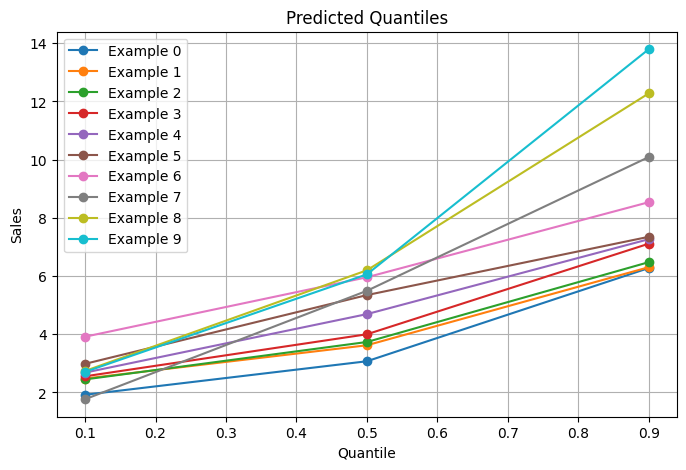

In [ ]:
# Predict quantiles
y_preds = {q: model.predict(X_val) for q, model in models.items()}
y_pred_df = pd.DataFrame(y_preds)

# Visualize some examples
plt.figure(figsize=(8, 5))
for i in range(min(10, len(y_val))):
    plt.plot([0.1, 0.5, 0.9], [y_pred_df.loc[i, 0.1], y_pred_df.loc[i, 0.5], y_pred_df.loc[i, 0.9]], marker='o', label=f'Example {i}')
plt.title("Predicted Quantiles")
plt.xlabel("Quantile")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for q in quantiles:
    loss = mean_pinball_loss(y_val, y_preds[q], alpha=q)
    print(f"Pinball loss for q={q}: {loss:.4f}")


Pinball loss for q=0.1: 0.2069
Pinball loss for q=0.5: 0.6326
Pinball loss for q=0.9: 0.3240


## 🔮 Preparing Future Data for Sales Forecasting (Sept 12–18, 2022)

This block creates the input dataset to generate sales forecasts for the next week (Sept 12–18, 2022) for all store-item pairs and prepares features for prediction.

---

### Step-by-step breakdown:

1. **Create Full Date-Store-Item Grid**
   - Generates all combinations of unique `(store_id, item_id)` pairs with each date in the forecast window (2022-09-12 to 2022-09-18).
   - Ensures complete coverage for prediction, even for pairs that may have missing dates in historical data.

2. **Add Calendar Features**
   - Extracts calendar-based features: `month`, `weekofyear` (ISO week), and `dayofweek` (numeric).
   - These help the model capture seasonal and weekly patterns in sales.

3. **Merge Historical Aggregated Features**
   - From historical data (up to Sept 10, 2022), extract latest rolling and lagged sales statistics per store-item.
   - This uses `.last()` after sorting by date to grab the most recent values, assuming these summarize the current sales trends.

4. **Merge Latest Pricing & Promotion Info**
   - Similarly, merge the most recent `regular_price`, `promo_price`, and `promo_flag` for each store-item.
   - This is crucial as pricing and promotions directly impact sales.

5. **Final Preparation**
   - Encodes `dayofweek` as categorical codes for model input compatibility.
   - Selects the relevant feature columns consistent with model training.

6. **Generate Predictions**
   - Uses previously trained quantile regression models to predict sales quantiles for each `(store_id, item_id, day)` combination.
   - Stores predictions for quantiles 10%, 50%, and 90% as new columns in `df_future`.

---

### 💡 Notes:

- Constructing the full grid avoids missing data issues during forecasting.
- Using the latest historical features assumes sales dynamics and promotions do not drastically change immediately.
- Calendar features ensure the model can leverage temporal seasonality.
- This approach allows batch prediction for the whole forecast horizon efficiently.
- Future improvements could include integrating planned promotions or price changes if known.

---


In [ ]:
# Create full date grid (12–18 Sept 2022 × all item/store pairs)

# Generate future dates
forecast_dates = pd.date_range('2022-09-12', '2022-09-18')

# Get all unique item-store combos
store_items = df[['store_id', 'item_id']].drop_duplicates()

# Create full grid
df_future = pd.DataFrame(
    list(product(store_items['store_id'], store_items['item_id'], forecast_dates)),
    columns=['store_id', 'item_id', 'daydt']
)

# Add calendar features
df_future['month'] = df_future['daydt'].dt.month
df_future['weekofyear'] = df_future['daydt'].dt.isocalendar().week
df_future['dayofweek'] = df_future['daydt'].dt.dayofweek

# Add rolling/statistical features from past
# We merge these from the latest available values in df, grouped by store_id, item_id and calendar key.

df_past = df[df['daydt'] < '2022-09-11']

# Choose latest snapshot per store/item
agg_cols = [
    'monthly_avg_sales_y', 'monthly_avg_sales_lag1', 'monthly_avg_sales_roll3',
    'weekly_avg_sales_y', 'weekly_avg_sales_lag1', 'weekly_avg_sales_roll3',
    'dow_avg_sales_y', 'dow_avg_sales_roll3'
]

latest_feats = df_past.sort_values('daydt').groupby(['store_id', 'item_id'])[agg_cols].last().reset_index()

# Merge into future dataframe
df_future = df_future.merge(latest_feats, on=['store_id', 'item_id'], how='left')

# Add regular/promo price and flags if known (optional)
# If we know the planned promotions or prices, merge them in. Otherwise, use the most recent known values:
price_cols = ['regular_price', 'promo_price', 'promo_flag']

latest_price = df_past.sort_values('daydt').groupby(['store_id', 'item_id'])[price_cols].last().reset_index()

df_future = df_future.merge(latest_price, on=['store_id', 'item_id'], how='left')


# Final cleanup
# Convert dayofweek to numeric codes
df_future['dayofweek'] = df_future['dayofweek'].astype('category').cat.codes

feature_cols = [
    'regular_price', 'promo_price', 'promo_flag',
    'monthly_avg_sales_y', 'monthly_avg_sales_lag1', 'monthly_avg_sales_roll3',
    'weekly_avg_sales_y', 'weekly_avg_sales_lag1', 'weekly_avg_sales_roll3',
    'dow_avg_sales_y', 'dow_avg_sales_roll3',
    'month', 'weekofyear', 'dayofweek'
]

X_future = df_future[feature_cols]

# Predict quantiles for each row
y_future_preds = {q: model.predict(X_future) for q, model in models.items()}

# Attach predictions to df_future
for q in y_future_preds:
    df_future[f'pred_q{int(q*100)}'] = y_future_preds[q]


## 📊 Visualization: Historical Sales and Forecasted Quantiles for a Store-Item Pair

This function generates an interactive Plotly time series plot combining:

- **Historical sales data**, including:
  - `sales` (possibly adjusted sales)
  - `sales_original` (original recorded sales)
  - `sales_depromo` (sales without promotion effects)

- **Forecasted sales quantiles** over a future horizon:
  - Median forecast (`pred_q50`)
  - Prediction interval represented by the 10th (`pred_q10`) and 90th (`pred_q90`) quantiles, shown as a shaded confidence band.

---

### Purpose:

Visual comparison of observed historical sales with predicted sales distribution for a specific `(store_id, item_id)` combination to evaluate forecast quality and uncertainty over time.

---

### Parameters:

- `df_past` (`pd.DataFrame`): Historical sales data. Must include columns:
  - `'store_id'`, `'item_id'`, `'daydt'` (datetime), `'sales'`, `'sales_original'`, `'sales_depromo'`

- `df_future` (`pd.DataFrame`): Forecast results. Must include columns:
  - `'store_id'`, `'item_id'`, `'daydt'` (datetime), `'pred_q10'`, `'pred_q50'`, `'pred_q90'`

- `store_id` (`int` or `str`): Store identifier for filtering

- `item_id` (`int` or `str`): Item identifier for filtering

---

### Output:

- Displays an interactive Plotly figure with:
  - Past sales lines and markers (blue, green dotted, black)
  - Forecast median line (red)
  - Shaded area representing the forecast range between 10th and 90th percentile quantiles

---

In [ ]:
def plot_forecast_with_history(
    df_past,      # original df with sales data
    df_future,    # future df with predicted quantiles
    store_id,
    item_id):
    """
    Plots historical sales data alongside forecasted sales quantiles for a specific store and item.

    This function visualizes past sales and future predictions, including specified quantiles, to help
    compare observed and forecasted values over time.

    Parameters:
    -----------
    df_past : pd.DataFrame
        DataFrame containing historical sales data. Must include columns such as 'store_id', 'item_id',
        'daydt' (date), and 'sales'.

    df_future : pd.DataFrame
        DataFrame containing forecasted sales quantiles. Expected to have columns like 'store_id', 'item_id',
        'daydt' (date), and predicted quantiles such as 'pred_q10', 'pred_q50', 'pred_q90', etc.

    store_id : int or str
        Identifier for the store to filter the data and focus the plot on.

    item_id : int or str
        Identifier for the item to filter the data and focus the plot on.

    Returns:
    --------
    None
        Displays a plot combining historical sales and forecasted quantiles over time.
    """

    # Filter past data
    history = df_past[(df_past['store_id'] == store_id) & (df_past['item_id'] == item_id)].copy()
    history = history.sort_values('daydt')

    # Filter future forecast
    forecast = df_future[(df_future['store_id'] == store_id) & (df_future['item_id'] == item_id)].copy()
    forecast = forecast.sort_values('daydt')

    fig = go.Figure()

    # Past sales
    fig.add_trace(go.Scatter(
        x=history['daydt'], y=history['sales'], name='sales', mode='lines+markers',
        line=dict(color='blue'), opacity=0.4
    ))
    fig.add_trace(go.Scatter(
        x=history['daydt'], y=history['sales_original'], name='sales_original', mode='lines+markers',
        line=dict(color='green', dash='dot'), opacity=0.4
    ))
    fig.add_trace(go.Scatter(
        x=history['daydt'], y=history['sales_depromo'], name='sales_depromo', mode='lines+markers',
        line=dict(color='black'), opacity=0.6
    ))

    # Forecast median (q50)
    fig.add_trace(go.Scatter(
        x=forecast['daydt'], y=forecast['pred_q50'], name='Forecast Median (q50)', mode='lines+markers',
        line=dict(color='red')
    ))

    # Forecast confidence band (q10 - q90)
    fig.add_trace(go.Scatter(
        x=pd.concat([forecast['daydt'], forecast['daydt'][::-1]]),
        y=pd.concat([forecast['pred_q90'], forecast['pred_q10'][::-1]]),
        fill='toself',
        fillcolor='rgba(255, 0, 0, 0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=True,
        name='Forecast Range (q10 - q90)'
    ))

    fig.update_layout(
        title=f"Forecast with History: {item_id} / {store_id}",
        xaxis_title="Date",
        yaxis_title="Sales",
        template="plotly_white",
        height=500
    )

    fig.show()


In [ ]:
df['combo'].unique()

array(['item1 / store1', 'item1 / store2', 'item2 / store2',
       'item4 / store2', 'item7 / store2', 'item5 / store3',
       'item6 / store3', 'item1 / store4', 'item6 / store4',
       'item7 / store4'], dtype=object)

In [ ]:
plot_forecast_with_history(df, df_future, store_id='store1', item_id='item1')

# Model Training

## 📈 Quantile Regression with LightGBM: Grid Search and Feature Importance

This script performs quantile regression modeling using LightGBM to predict sales quantiles, with hyperparameter tuning via grid search and visualization of feature importance.

---

### Key Components:

1. **Quantile Loss Function (`quantile_loss`)**  
   Implements the pinball loss used to evaluate quantile regression performance at a specified quantile `q`.

2. **Grid Search for LightGBM Quantile Models (`grid_search_lgb_quantiles`)**  
   - Performs a grid search over specified hyperparameters using **time series cross-validation** (`TimeSeriesSplit`).  
   - Trains LightGBM models with quantile regression objective (`objective='quantile'` and `alpha=q`).  
   - Returns a sorted DataFrame with hyperparameter sets and their average quantile loss.

3. **Feature Importance Plot (`plot_feature_importance`)**  
   Visualizes the top `max_num` features based on importance scores from the trained LightGBM model.

---

### Workflow:

- **Data Preparation**  
  - Maps day-of-week strings to numeric codes (`dow_mapping`).  
  - Defines a consistent set of features relevant for sales forecasting (`feature_cols`).  
  - Prepares feature matrix `X` and target variable `y` (here: `sales_depromo`).

- **Hyperparameter Tuning**  
  - Runs `grid_search_lgb_quantiles` with default parameter grid for the median quantile (q=0.5).  
  - Selects best hyperparameters based on cross-validated quantile loss.

- **Model Training and Interpretation**  
  - Fits final LightGBM quantile regression model on full dataset using the best hyperparameters.  
  - Plots feature importance to interpret which predictors drive the model.

---

### Parameters Summary:

- `X` (`pd.DataFrame`): Feature matrix.  
- `y` (`pd.Series`): Target variable.  
- `q` (`float`): Quantile to predict (default 0.5 for median).  
- `param_grid` (`dict`): Hyperparameters and values for grid search.  
- `cv_folds` (`int`): Number of time series splits for cross-validation (default 3).  
- `time_column` (`str`): Column name with temporal info (optional).

---

### 💡 Notes:
- The time series split respects temporal order to avoid leakage.
- Quantile loss provides asymmetric penalties, useful for probabilistic forecasting.
- Feature importance helps identify which variables contribute most to the predictions.


In [ ]:
def quantile_loss(y_true, y_pred, q):
    """
    Calculates the quantile loss (also known as pinball loss) between true and predicted values at a given quantile.

    Quantile loss measures the accuracy of a prediction model in estimating a specified quantile of the target distribution.

    Parameters:
    -----------
    y_true : array-like
        True target values (ground truth).

    y_pred : array-like
        Predicted values from the model for the target variable.

    q : float
        Quantile to evaluate, between 0 and 1 (e.g., 0.5 for median).

    Returns:
    --------
    float
        The computed quantile loss, representing the weighted difference between true and predicted values at quantile `q`.
    """
    delta = y_true - y_pred
    return np.maximum(q * delta, (q - 1) * delta).mean()

def grid_search_lgb_quantiles(
    X, y, q=0.5,
    param_grid=None,
    cv_folds=3,
    time_column=None):
    """
    Performs grid search to tune LightGBM quantile regression model hyperparameters using time series cross-validation.

    This function searches over a parameter grid to find the best hyperparameters that minimize quantile loss
    for a specified quantile level, respecting the temporal order of the data.

    Parameters:
    -----------
    X : pd.DataFrame or array-like
        Feature matrix containing the independent variables used for training.

    y : pd.Series or array-like
        Target variable values corresponding to `X`.

    q : float
        Quantile level to be predicted (between 0 and 1), used as the objective in LightGBM quantile regression.

    param_grid : dict
        Dictionary specifying hyperparameters and their respective values to be searched during grid search.

    cv_folds : int, optional, default=3
        Number of folds for time series cross-validation splits.

    time_column : str
        Name of the column in the dataset containing time or timestamp information, used to ensure proper temporal splits.

    Returns:
    --------
    pd.DataFrame
        DataFrame summarizing the grid search results, including tested hyperparameter combinations and their corresponding average cross-validated quantile loss.
    """
    if param_grid is None:
        param_grid = {
            'num_leaves': [15, 31],
            'min_data_in_leaf': [10, 30],
            'learning_rate': [0.05, 0.1],
            'n_estimators': [100, 300],
        }

    results = []
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    grid = list(ParameterGrid(param_grid))

    for params in tqdm(grid):
        losses = []
        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = lgb.LGBMRegressor(
                objective='quantile',
                alpha=q,
                **params
            )
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            loss = quantile_loss(y_val, y_pred, q)
            losses.append(loss)

        avg_loss = np.mean(losses)
        results.append({'params': params, 'cv_loss': avg_loss})

    results_df = pd.DataFrame(results).sort_values('cv_loss')
    return results_df

def plot_feature_importance(model, feature_names, max_num=20):
    """
    Generates a horizontal bar plot to visualize the importance of features from a trained model.

    Parameters:
    -----------
    model : object
        A trained machine learning model that exposes features' importance (e.g., decision tree, random forest,
        gradient boosting models).

    feature_names : list of str
        List of feature names corresponding to the features used by the model. These names will be shown on the plot.

    max_num : int, optional (default=20)
        Maximum number of top features to display in the plot, sorted by importance.

    Returns:
    --------
    None
        Displays a horizontal bar plot of features' importance.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:max_num]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.barh(range(len(indices)), importances[indices][::-1], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices][::-1])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


  0%|          | 0/16 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

  6%|▋         | 1/16 [00:00<00:11,  1.25it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 12%|█▎        | 2/16 [00:01<00:12,  1.11it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 19%|█▉        | 3/16 [00:03<00:15,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 25%|██▌       | 4/16 [00:05<00:18,  1.50s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

 31%|███▏      | 5/16 [00:05<00:12,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

 38%|███▊      | 6/16 [00:06<00:09,  1.07it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

 44%|████▍     | 7/16 [00:07<00:08,  1.10it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

 50%|█████     | 8/16 [00:08<00:08,  1.01s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 56%|█████▋    | 9/16 [00:08<00:05,  1.26it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 9105, number of used features: 14
[LightGBM] [Info] Start training from score 2.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_d

 62%|██████▎   | 10/16 [00:09<00:04,  1.46it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 69%|██████▉   | 11/16 [00:10<00:03,  1.36it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 75%|███████▌  | 12/16 [00:11<00:03,  1.06it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

 81%|████████▏ | 13/16 [00:11<00:02,  1.33it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 9105, number of used features: 14
[LightGBM] [Info] Start training from score 2.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_d

 88%|████████▊ | 14/16 [00:12<00:01,  1.52it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

 94%|█████████▍| 15/16 [00:13<00:00,  1.39it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 12140, number of used features: 14
[LightGBM] [Info] Start training from score 1.000000


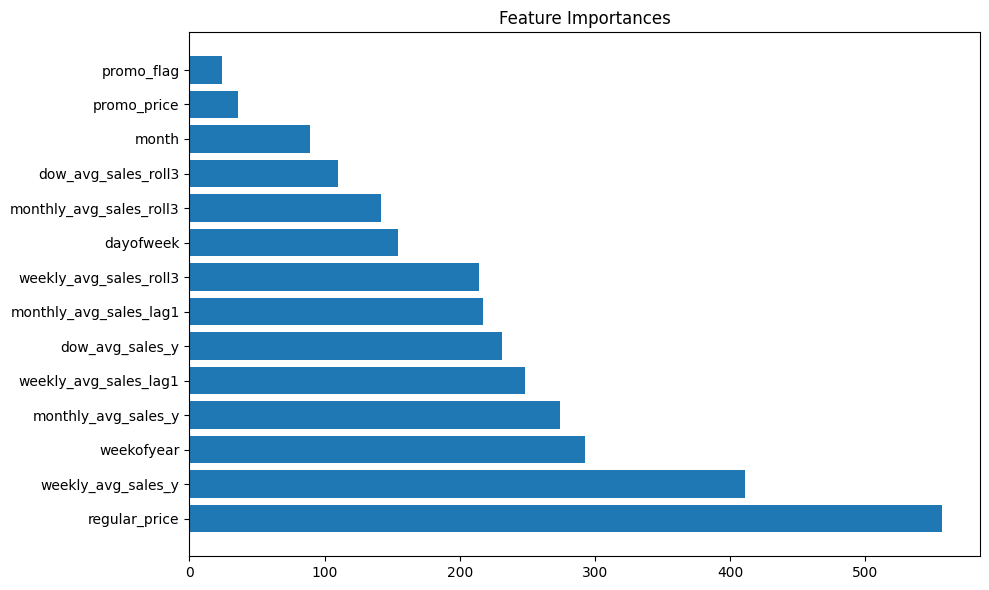

In [ ]:
feature_cols = [
    'regular_price', 'promo_price', 'promo_flag',
    'monthly_avg_sales_y', 'monthly_avg_sales_lag1', 'monthly_avg_sales_roll3',
    'weekly_avg_sales_y', 'weekly_avg_sales_lag1', 'weekly_avg_sales_roll3',
    'dow_avg_sales_y', 'dow_avg_sales_roll3',
    'month', 'weekofyear', 'dayofweek'
]

dow_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['dayofweek'] = df['dayofweek'].map(dow_mapping)

X = df[feature_cols]
y = df['sales_depromo']

# Grid search for q=0.5
results = grid_search_lgb_quantiles(X, y, q=0.5)

# Best model
best_params = results.iloc[0]['params']
best_model = lgb.LGBMRegressor(objective='quantile', alpha=0.5, **best_params)
best_model.fit(X, y)

# Feature importance
plot_feature_importance(best_model, X.columns)


## Multi-Quantile LightGBM Regression with Grid Search and Forecasting

This code defines functions to train and tune LightGBM quantile regression models over multiple quantiles (e.g., 0.1, 0.5, 0.9) using time series cross-validation, then generate predictions for each quantile on future data.

---

### Functions

#### 1. `run_lgb_grid_search_all_quantiles`

- **Purpose:**  
  Runs a hyperparameter grid search for LightGBM quantile regression models at multiple quantiles.  
  For each quantile, it performs time series cross-validation and selects the best model minimizing the quantile (pinball) loss.

- **Inputs:**  
  - `X` (`pd.DataFrame`): Feature matrix.  
  - `y` (`pd.Series`): Target variable.  
  - `quantiles` (`list` of float): Quantiles to model (default `[0.1, 0.5, 0.9]`).  
  - `cv_folds` (`int`): Number of folds for time series splitting (default 3).  
  - `param_grid` (`dict`): Hyperparameter values for grid search.

- **Outputs:**  
  - `best_models` (`dict`): Best trained LightGBM models for each quantile.  
  - `best_params` (`dict`): Best hyperparameters for each quantile.

- **Workflow:**  
  For each quantile `q`:
  - Iterate over all hyperparameter combinations.  
  - For each, do a time series cross-validation split: train and validate model.  
  - Calculate quantile loss on validation set.  
  - Track the best model and hyperparameters per quantile.  
  - Refit the best model on the full training set.

---

#### 2. `forecast_all_quantiles`

- **Purpose:**  
  Use trained quantile models to predict multiple quantiles on future feature data.

- **Inputs:**  
  - `models` (`dict`): Quantile models keyed by quantile values (e.g., 0.1, 0.5, 0.9).  
  - `X_future` (`pd.DataFrame`): Future data with features and identifying columns (`daydt`, `item_id`, `store_id`).

- **Output:**  
  - `pd.DataFrame`: DataFrame including `daydt`, `item_id`, `store_id` and predicted quantiles (e.g., `pred_q10`, `pred_q50`, `pred_q90`).

---

### 💡 Notes
- Uses TimeSeriesSplit to avoid leakage in time series data.
- Quantile regression estimates prediction intervals instead of single point estimates.
- The returned pred_df can be used for downstream evaluation or visualization of forecast uncertainty.

This approach enables robust probabilistic forecasting with model selection tailored to each quantile.


In [ ]:
# Grid search function per quantile
def run_lgb_grid_search_all_quantiles(X, y, quantiles=[0.1, 0.5, 0.9], cv_folds=3, param_grid=None):
    """
    Performs grid search hyperparameter tuning for LightGBM quantile regression models across multiple quantiles
    using time series cross-validation.

    This function iterates over a list of quantiles, conducting a separate grid search for each to identify
    the best LightGBM model parameters that minimize the quantile loss.

    Parameters:
    -----------
    X : pd.DataFrame or array-like
        Feature matrix containing the independent variables used for training.

    y : pd.Series or array-like
        Target variable values corresponding to `X`.

    quantiles : list of float
        List of quantile levels (values between 0 and 1) for which to run the grid search, e.g., [0.1, 0.5, 0.9].

    cv_folds : int, optional (default=3)
        Number of folds to use in time series cross-validation.

    param_grid : dict
        Dictionary specifying the hyperparameters and their candidate values for grid search.

    Returns:
    --------
    best_models : dict
        Dictionary mapping each quantile to the corresponding best LightGBM model found.

    best_params : dict
        Dictionary mapping each quantile to the best hyperparameters identified during grid search.
    """
    best_models = {}
    best_params = {}

    if param_grid is None:
        param_grid = {
            'num_leaves': [15, 31],
            'min_data_in_leaf': [10, 30],
            'learning_rate': [0.05],
            'n_estimators': [100, 300],
        }

    for q in quantiles:
        print(f"Running grid search for quantile: {q}")
        grid = list(ParameterGrid(param_grid))
        tscv = TimeSeriesSplit(n_splits=cv_folds)

        best_loss = float("inf")
        best_model = None
        best_param = None

        for params in tqdm(grid):
            losses = []
            for train_idx, val_idx in tscv.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                model = lgb.LGBMRegressor(objective='quantile', alpha=q, **params)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)

                loss = np.mean(np.maximum(q * (y_val - y_pred), (q - 1) * (y_val - y_pred)))
                losses.append(loss)

            avg_loss = np.mean(losses)
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_model = lgb.LGBMRegressor(objective='quantile', alpha=q, **params)
                best_model.fit(X, y)
                best_param = params

        best_models[q] = best_model
        best_params[q] = best_param

    return best_models, best_params

def forecast_all_quantiles(models, X_future):
    """
    Generates forecasts for multiple quantiles using a dictionary of trained quantile regression models.

    Parameters:
    -----------
    models : dict
        Dictionary where keys are quantile levels (e.g., 0.1, 0.5, 0.9) and values are corresponding
        trained quantile regression models.

    X_future : pd.DataFrame
        DataFrame containing future feature data for prediction. Must include columns such as
        'daydt', 'item_id', 'store_id', and any other features required by the models.

    Returns:
    --------
    pd.DataFrame
        DataFrame with predictions for each specified quantile. Includes columns for 'daydt', 'item_id',
        'store_id', and predicted quantile values for each model in the `models` dictionary.
    """

    pred_df = X_future[['daydt', 'item_id', 'store_id']].copy()
    for q, model in models.items():
        pred_df[f'pred_q{int(q*100)}'] = model.predict(X_future.drop(columns=['daydt', 'item_id', 'store_id']))
    return pred_df



In [ ]:
feature_cols = [
    'regular_price', 'promo_price', 'promo_flag',
    'monthly_avg_sales_y', 'monthly_avg_sales_lag1', 'monthly_avg_sales_roll3',
    'weekly_avg_sales_y', 'weekly_avg_sales_lag1', 'weekly_avg_sales_roll3',
    'dow_avg_sales_y', 'dow_avg_sales_roll3',
    'month', 'weekofyear', 'dayofweek'
]

X_train = df[feature_cols]
y_train = df['sales_depromo']

# Fit best models for 0.1, 0.5, 0.9
models, params = run_lgb_grid_search_all_quantiles(X_train, y_train)

# Predict on future
X_future = df_future[feature_cols + ['daydt', 'item_id', 'store_id']]
pred_df = forecast_all_quantiles(models, X_future)


Running grid search for quantile: 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 1.358103
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 12%|█▎        | 1/8 [00:00<00:03,  2.23it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 1.358103
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 1.358103
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 38%|███▊      | 3/8 [00:02<00:05,  1.06s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 1.358103
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 50%|█████     | 4/8 [00:04<00:05,  1.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 1.358103
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

 62%|██████▎   | 5/8 [00:05<00:03,  1.03s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 1.358103
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

 75%|███████▌  | 6/8 [00:05<00:01,  1.21it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 9105, number of used features: 14
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf 

 88%|████████▊ | 7/8 [00:06<00:00,  1.09it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 1.358103
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Running grid search for quantile: 0.5


  0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 12140, number of used features: 14
[LightGBM] [Info] Start training from score 1.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_

 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 38%|███▊      | 3/8 [00:02<00:04,  1.15it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_da

 50%|█████     | 4/8 [00:03<00:04,  1.08s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

 62%|██████▎   | 5/8 [00:04<00:02,  1.22it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 9105, number of used features: 14
[LightGBM] [Info] Start training from score 2.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_d

 75%|███████▌  | 6/8 [00:05<00:01,  1.17it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

 88%|████████▊ | 7/8 [00:05<00:00,  1.17it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 5.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_da

100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Running grid search for quantile: 0.9


  0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 12.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_d

 12%|█▎        | 1/8 [00:01<00:07,  1.00s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 12.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_d

 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 9105, number of used features: 14
[LightGBM] [Info] Start training from score 10.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_

 38%|███▊      | 3/8 [00:02<00:03,  1.39it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 12.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_d

 50%|█████     | 4/8 [00:03<00:04,  1.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 12.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_d

 62%|██████▎   | 5/8 [00:04<00:02,  1.14it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 12140, number of used features: 14
[LightGBM] [Info] Start training from score 9.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_

 75%|███████▌  | 6/8 [00:04<00:01,  1.38it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 12.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_d

 88%|████████▊ | 7/8 [00:05<00:00,  1.18it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3035, number of used features: 14
[LightGBM] [Info] Start training from score 12.000000
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_d

100%|██████████| 8/8 [00:07<00:00,  1.11it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


In [ ]:
plot_forecast_with_history(df, pred_df, store_id='store1', item_id='item1')

## Discrete Probability Distribution from Quantile Predictions and Animated Forecast Plot

---

### Function: `build_discrete_distribution`

Constructs a discrete probability mass function (PMF) from predicted quantiles for a given data row.

**Description:**  
Given predicted quantiles (e.g., 0.1, 0.5, 0.9) of demand for a single observation (row), this function approximates a cumulative distribution function (CDF) by interpolating between quantile values over a specified discrete demand range. It then calculates a discrete PMF by differencing the interpolated CDF values for consecutive demand points, ensuring probabilities sum to 1.

**Parameters:**  
- `row` (`pd.Series` or `dict`): Contains predicted quantile values, keyed like `pred_q10`, `pred_q50`, `pred_q90`.  
- `demand_range` (`range` or `list`): Discrete demand values over which to compute the PMF (default 0 to 20).  
- `quantiles` (`list` of float): Quantile levels corresponding to predictions in `row` (default `[0.1, 0.5, 0.9]`).

**Returns:**  
- `dict`: Keys are demand values in `demand_range`, values are probabilities forming a discrete PMF. NaNs returned if predictions are invalid.

---

### Function: `plot_animated_forecast_distribution`

Generates an animated plot visualizing the forecast PMF over time for a specific item and store.

**Description:**  
Given a DataFrame containing PMFs over dates for an item-store pair, this function creates an interactive animated bar chart. Each frame shows the PMF (demand probabilities) for a particular date. An optional parameter allows displaying past sales data as part of the animation.

**Parameters:**  
- `pred_df` (`pd.DataFrame`): DataFrame with forecast PMFs and columns including `item_id`, `store_id`, `daydt`, and `pmf` (dict of demand → probability).  
- `item_id` (scalar): Identifier for the item to filter and plot.  
- `store_id` (scalar): Identifier for the store to filter and plot.  
- `demand_range` (`range` or `list`): Range of demand values to display (default 0 to 20).  
- `show_past_sales` (`bool`): Whether to include past sales data in the animation (default True).

**Outputs:**  
- Displays an interactive Plotly animated bar chart showing the forecast PMF across dates.

---

### 💡 Notes
- Monotonicity of quantile values is enforced before interpolation to avoid invalid CDF shapes.
- PMF probabilities are clipped between 0 and 1 and normalized to sum to 1 for valid probability distribution.
- Animation uses Plotly for rich interactive visualization with sliders for time navigation.
- This approach visualizes uncertainty in demand forecasts by showing full probability distributions rather than single point estimates.


In [ ]:
def build_discrete_distribution(row, demand_range=range(0, 21), quantiles=[0.1, 0.5, 0.9]):
    """
    Constructs a discrete probability mass function (PMF) from predicted quantiles for a given data row.

    This function uses predicted quantiles to build an approximate cumulative distribution function (CDF),
    then interpolates it over a specified demand range to obtain a discrete PMF representing the probability
    distribution of demand.

    Parameters:
    -----------
    row : pd.Series or dict
        A single row of data containing predicted quantile values for demand. Quantile values should correspond
        to the quantiles specified in the `quantiles` parameter.

    demand_range : range or list, optional (default=range(0, 21))
        Range of discrete demand values over which to compute the PMF. Typically a sequence of integer demand
        values.

    quantiles : list of float
        List of quantile levels (between 0 and 1) corresponding to the predicted quantiles present in `row`.

    Returns:
    --------
    dict
        A dictionary representing the discrete PMF, where keys are demand values within `demand_range` and
        values are the corresponding probabilities derived from the interpolated CDF. The function ensures
        that the quantiles are monotonic and the resulting PMF sums to 1.
    """
    q_vals = [row.get(f'pred_q{int(q*100)}') for q in quantiles]

    # Handle invalid rows (e.g., all NaNs)
    if any(pd.isna(q_vals)):
        return {d: np.nan for d in demand_range}

    # Ensure monotonicity
    q_vals = np.maximum.accumulate(q_vals)

    # Construct interpolated CDF
    cdf_func = interp1d(q_vals, quantiles, bounds_error=False, fill_value=(0.0, 1.0))

    pmf = {}
    prev_cdf = 0
    for d in demand_range:
        cdf = float(cdf_func(d))
        prob = cdf - prev_cdf
        pmf[d] = max(0.0, min(prob, 1.0))  # clip between 0 and 1
        prev_cdf = cdf

    # Normalize to sum to 1
    total = sum(pmf.values())
    if total > 0:
        pmf = {k: v / total for k, v in pmf.items()}
    else:
        pmf = {k: 0.0 for k in pmf}

    return pmf


In [ ]:
pred_df['pmf'] = pred_df.apply(build_discrete_distribution, axis=1)

In [ ]:
pred_df

,daydt,item_id,store_id,pred_q10,pred_q50,pred_q90,pmf
0,2022-09-12,item1,store1,1.888864,4.664338,7.300856,"{0: 0.0, 1: 0.0, 2: 0.11601691729006791, 3: 0...."
1,2022-09-13,item1,store1,1.910341,4.654751,7.300856,"{0: 0.0, 1: 0.0, 2: 0.11306783306161605, 3: 0...."
2,2022-09-14,item1,store1,1.910341,4.591930,7.300856,"{0: 0.0, 1: 0.0, 2: 0.11337397114317375, 3: 0...."
3,2022-09-15,item1,store1,1.910341,4.889246,7.300856,"{0: 0.0, 1: 0.0, 2: 0.11203915434013045, 3: 0...."
4,2022-09-16,item1,store1,2.002789,4.889246,7.300856,"{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.2381916926088310..."
...,...,...,...,...,...,...,...
695,2022-09-14,item7,store4,0.000000,0.005921,1.047364,"{0: 0.1, 1: 0.7818082404047039, 2: 0.118191759..."
696,2022-09-15,item7,store4,0.000000,0.005921,1.047364,"{0: 0.1, 1: 0.7818082404047039, 2: 0.118191759..."
697,2022-09-16,item7,store4,0.000000,0.005921,1.047364,"{0: 0.1, 1: 0.7818082404047039, 2: 0.118191759..."
698,2022-09-17,item7,store4,0.000000,0.005921,1.047364,"{0: 0.1, 1: 0.7818082404047039, 2: 0.118191759..."


In [ ]:
pred_df[['daydt', 'item_id', 'store_id', "pmf"]].to_csv("pred_pmf.csv", index=False)

In [ ]:
def plot_animated_forecast_distribution(pred_df, item_id, store_id, demand_range=range(0, 21), show_past_sales=True):
    """
    Creates an animated plot showing the forecasted probability mass function (PMF) of demand for a specific item at a store over time.

    The animation visualizes how the predicted demand distribution evolves across a series of dates, optionally including past sales data for context.

    Parameters:
    -----------
    pred_df : pd.DataFrame
        DataFrame containing forecasted PMFs for demand, with columns such as 'item_id', 'store_id',
        'daydt' (date), and the PMF values for the demand range.

    item_id : int or str
        Unique identifier for the item to filter the data and focus the animation on.

    store_id : int or str
        Unique identifier for the store to filter the data and focus the animation on.

    demand_range : range or list, optional (default=range(0, 21))
        Range of discrete demand values included in the PMF plots.

    show_past_sales : bool, optional (default=True)
        Whether to overlay past sales data in the animation to provide historical context.

    Returns:
    --------
    None
        Displays an animated visualization of the forecasted demand distribution over time.
    """

    # Filter data
    df_subset = pred_df[(pred_df['item_id'] == item_id) & (pred_df['store_id'] == store_id)].copy()
    df_subset = df_subset.sort_values("daydt")

    fig = go.Figure()

    for _, row in df_subset.iterrows():
        date_str = row["daydt"].strftime("%Y-%m-%d")
        pmf = row["pmf"]
        if pmf is None or not isinstance(pmf, dict):
            continue

        fig.add_trace(go.Bar(
            x=list(pmf.keys()),
            y=list(pmf.values()),
            name=f"{date_str}",
            visible=False,
        ))

    # First trace is visible
    fig.data[0].visible = True

    # Frames for animation
    steps = []
    for i, row in enumerate(df_subset.itertuples()):
        date_str = row.daydt.strftime("%Y-%m-%d")
        step = dict(
            method="update",
            args=[{"visible": [j == i for j in range(len(df_subset))]},
                  {"title": f"Forecast PMF for {item_id} @ {store_id} on {date_str}"}],
            label=date_str
        )
        steps.append(step)

    sliders = [dict(
        active=0,
        pad={"t": 50},
        steps=steps
    )]

    fig.update_layout(
        sliders=sliders,
        title=f"Forecast PMF for {item_id} @ {store_id}",
        xaxis_title="Demand",
        yaxis_title="Probability",
        showlegend=False
    )

    fig.show()

In [ ]:
plot_animated_forecast_distribution(pred_df, item_id="item1", store_id="store1")

# Overview

## Final Thoughts on Using LightGBM Quantile Regression, Discrete PMF, and Pinball Loss

---

### Why LightGBM with Quantile Regression?

- **Capturing uncertainty:**  
  Traditional regression predicts a single point estimate (e.g., the mean), but in many real-world forecasting problems—like demand prediction—it’s crucial to quantify uncertainty. LightGBM's **quantile regression objective** allows us to directly estimate different quantiles (e.g., 10th, 50th, 90th percentiles) of the target distribution, providing a richer probabilistic forecast.

- **Scalability and performance:**  
  LightGBM is a fast, scalable gradient boosting framework that handles large datasets and complex feature interactions efficiently. Its support for quantile regression makes it well-suited for demand forecasting tasks with time series and structured features.

---

### Why Construct a Discrete Probability Mass Function (PMF) from Quantiles?

- **From quantiles to full distribution:**  
  Quantile predictions give us a few points on the cumulative distribution function (CDF) but not the full distribution shape. By interpolating these quantiles and converting them into a discrete PMF, we obtain an approximate **probability distribution over all plausible demand values**.

- **Decision making under uncertainty:**  
  Having a full discrete PMF allows downstream tasks (inventory optimization, risk assessment, service level calculations) to leverage the complete uncertainty profile of demand rather than relying on point forecasts alone.

- **Flexibility and interpretability:**  
  The PMF can be easily visualized (as in the animated forecast plots), enabling stakeholders to see the likelihood of different demand outcomes across time.

---

### What is Pinball Loss and Why Use It for Evaluation?

- **Definition:**  
  The **pinball loss** (also called quantile loss) is a loss function designed specifically for evaluating quantile regression models. For a quantile \( q \), it penalizes under-predictions and over-predictions asymmetrically, reflecting the quantile’s position:
  
  The pinball loss for quantile *q* is defined as:
  - If the true value \( y \) is greater than the prediction $(\hat{y})$,  
  the loss is:  $( L_q = q \times (y - \hat{y}) )$
  - Otherwise (if $( y \leq \hat{y} )$),  
  the loss is:  $( L_q = (q - 1) \times (y - \hat{y}) )$

  In other words:  
  $
  L_q(y, \hat{y}) =
  \begin{cases}
  q \times (y - \hat{y}), & \text{if } y > \hat{y} \\
  (q - 1) \times (y - \hat{y}), & \text{if } y \leq \hat{y}
  \end{cases}
  $

- **Interpretation:**  
  This loss encourages the model to estimate the \( q \)-th quantile correctly by weighting errors differently depending on whether predictions are above or below the true values. For example, the 0.9 quantile model is penalized more for underestimating demand than overestimating it.

- **Why it’s suitable:**  
  Unlike mean squared error or mean absolute error, pinball loss directly measures the accuracy of the predicted quantiles, making it the natural metric to evaluate and optimize quantile regression models.

#### What Is a Good Pinball Loss?

- **Scale-dependent:**  
  Pinball loss values depend on the scale of the target variable. For example, if your demand values range from 0 to 100, a pinball loss of 5 might be reasonable, but the same loss on a target ranging 0 to 10 would be poor.

- **Lower is better:**  
  Pinball loss measures the average weighted error at a given quantile. The closer it is to **0**, the better the quantile predictions fit the true distribution.

- **Context matters:**  
  What counts as a "good" pinball loss depends on your application’s tolerance for error and the inherent noise in the data. Comparing pinball loss against:
  - A naive baseline (e.g., predicting the historical quantile or mean),
  - Other models or parameter sets,
  is the best way to interpret whether your loss is acceptable.

- **Relative improvements:**  
  Even small reductions in pinball loss can translate into significantly better quantile forecasts and improved decision-making downstream.

- **In short**:
  A good pinball loss is **as low as possible relative to baselines and alternative models**, indicating your quantile predictions closely approximate the true conditional quantiles of the demand distribution.

---

### Summary

By combining LightGBM quantile regression, discrete PMF construction, and pinball loss evaluation, we build a robust and interpretable probabilistic demand forecasting pipeline that:

- Efficiently models uncertainty at multiple quantiles,
- Transforms quantile predictions into usable probability distributions,
- And evaluates model performance with a metric tailored to quantile accuracy.

This approach enables better decision-making under uncertainty in demand-driven business contexts.

